In [3]:
# ============================================================
# 02_feature_engineering.ipynb
# Feature Engineering for Mobility SLA Risk Prediction
# ============================================================

# 0️⃣ Setup imports and paths
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from config import RAW_PATH, PROCESSED_PATH
from data_processing import load_raw_data, clean_data, save_processed_data

sns.set(style="whitegrid")



In [4]:
# 1️⃣ Load + clean
df_raw = load_raw_data(RAW_PATH)
df = clean_data(df_raw)

print("Raw shape:", df_raw.shape)
print("Clean shape:", df.shape)
df.head()

Loaded raw dataset: 5000 rows, 15 columns
Raw shape: (5000, 15)
Clean shape: (5000, 15)


,case_id,case_type,country,processing_stage,office_id,office_load,priority,document_complexity,documents_missing,client_response_delay_days,reassignment_count,days_in_stage,sla_target_days,total_processing_days,sla_breach
0,1,Tax,CA,Intake,106,51,Normal,Medium,1,18,1,3,21,43.7,1
1,2,Relocation,DE,Government Review,119,34,Normal,Low,6,4,2,4,35,65.2,1
2,3,Relocation,DE,Government Review,114,121,Urgent,Low,1,25,0,40,28,85.6,1
3,4,Visa Renewal,DE,Intake,110,94,Normal,Low,2,4,0,33,30,49.7,1
4,5,Tax,UK,Documentation,107,85,Normal,Medium,0,7,1,20,21,45.4,1


2️⃣ Examine the data

In [5]:
# Overview
df.info()
df.describe(include='all')

# Check missing values
df.isna().sum()

# Quick value counts for categorical columns
for col in df.select_dtypes(include='object').columns:
    print(col, df[col].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   case_id                     5000 non-null   int64  
 1   case_type                   5000 non-null   object 
 2   country                     5000 non-null   object 
 3   processing_stage            5000 non-null   object 
 4   office_id                   5000 non-null   int64  
 5   office_load                 5000 non-null   int64  
 6   priority                    5000 non-null   object 
 7   document_complexity         5000 non-null   object 
 8   documents_missing           5000 non-null   int64  
 9   client_response_delay_days  5000 non-null   int64  
 10  reassignment_count          5000 non-null   int64  
 11  days_in_stage               5000 non-null   int64  
 12  sla_target_days             5000 non-null   int64  
 13  total_processing_days       5000 

3️⃣ Identify Features and Target

In [6]:
# 2️⃣ Define leakage-safe and leakage-prone columns

TARGET_COL = "sla_breach"

# Columns that should NEVER be used for early-warning prediction
LEAKAGE_COLS = [
    "total_processing_days",  # known only after case completes
]

# Columns that are identifiers (drop them for modeling)
ID_COLS = [
    "case_id",
]

# (Optional) if you consider office_id to be too identifying, keep it but model carefully.
# We'll keep it because it can represent workload/process differences across offices.
# If you want to drop it later, just add "office_id" to ID_COLS.


In [7]:
# 3️⃣ Create derived / engineered features (early-warning friendly)

df_fe = df.copy()

# --- Basic ratios and interactions ---
# How tight is the SLA relative to delay drivers?
df_fe["docs_per_sla"] = df_fe["documents_missing"] / df_fe["sla_target_days"].replace(0, np.nan)
df_fe["client_delay_per_sla"] = df_fe["client_response_delay_days"] / df_fe["sla_target_days"].replace(0, np.nan)

# workload intensity proxy
df_fe["load_x_reassign"] = df_fe["office_load"] * (df_fe["reassignment_count"] + 1)

# stage pressure: days spent in current stage relative to SLA target
df_fe["stage_time_ratio"] = df_fe["days_in_stage"] / df_fe["sla_target_days"].replace(0, np.nan)

# missing docs severity bucket (helps interpretability)
df_fe["missing_docs_bucket"] = pd.cut(
    df_fe["documents_missing"],
    bins=[-1, 0, 2, 4, 10],
    labels=["0", "1-2", "3-4", "5+"]
)

# workload bucket (helps non-linear effects)
df_fe["office_load_bucket"] = pd.qcut(df_fe["office_load"], q=4, labels=["low", "mid", "high", "very_high"])

# client delay bucket
df_fe["client_delay_bucket"] = pd.cut(
    df_fe["client_response_delay_days"],
    bins=[-1, 0, 7, 14, 30, 365],
    labels=["0", "1-7", "8-14", "15-30", "30+"]
)

# urgent flag (if priority exists)
if "priority" in df_fe.columns:
    df_fe["is_urgent"] = (df_fe["priority"].astype(str).str.lower() == "urgent").astype(int)

df_fe.head()


,case_id,case_type,country,processing_stage,office_id,office_load,priority,document_complexity,documents_missing,client_response_delay_days,...,total_processing_days,sla_breach,docs_per_sla,client_delay_per_sla,load_x_reassign,stage_time_ratio,missing_docs_bucket,office_load_bucket,client_delay_bucket,is_urgent
0,1,Tax,CA,Intake,106,51,Normal,Medium,1,18,...,43.7,1,0.047619,0.857143,102,0.142857,1-2,mid,15-30,0
1,2,Relocation,DE,Government Review,119,34,Normal,Low,6,4,...,65.2,1,0.171429,0.114286,102,0.114286,5+,low,1-7,0
2,3,Relocation,DE,Government Review,114,121,Urgent,Low,1,25,...,85.6,1,0.035714,0.892857,121,1.428571,1-2,very_high,15-30,1
3,4,Visa Renewal,DE,Intake,110,94,Normal,Low,2,4,...,49.7,1,0.066667,0.133333,94,1.100000,1-2,high,1-7,0
4,5,Tax,UK,Documentation,107,85,Normal,Medium,0,7,...,45.4,1,0.000000,0.333333,170,0.952381,0,high,1-7,0


In [8]:
# 4️⃣ Prepare modeling datasets

# Early-warning dataset (NO leakage)
early_warning_drop = ID_COLS + LEAKAGE_COLS
early_warning_cols = [c for c in df_fe.columns if c not in early_warning_drop]

df_early = df_fe[early_warning_cols].copy()

# Ensure target is numeric 0/1 for modeling consistency
df_early[TARGET_COL] = df_early[TARGET_COL].astype(int)

print("Early-warning dataset shape:", df_early.shape)
df_early.head()


Early-warning dataset shape: (5000, 21)


,case_type,country,processing_stage,office_id,office_load,priority,document_complexity,documents_missing,client_response_delay_days,reassignment_count,...,sla_target_days,sla_breach,docs_per_sla,client_delay_per_sla,load_x_reassign,stage_time_ratio,missing_docs_bucket,office_load_bucket,client_delay_bucket,is_urgent
0,Tax,CA,Intake,106,51,Normal,Medium,1,18,1,...,21,1,0.047619,0.857143,102,0.142857,1-2,mid,15-30,0
1,Relocation,DE,Government Review,119,34,Normal,Low,6,4,2,...,35,1,0.171429,0.114286,102,0.114286,5+,low,1-7,0
2,Relocation,DE,Government Review,114,121,Urgent,Low,1,25,0,...,28,1,0.035714,0.892857,121,1.428571,1-2,very_high,15-30,1
3,Visa Renewal,DE,Intake,110,94,Normal,Low,2,4,0,...,30,1,0.066667,0.133333,94,1.100000,1-2,high,1-7,0
4,Tax,UK,Documentation,107,85,Normal,Medium,0,7,1,...,21,1,0.000000,0.333333,170,0.952381,0,high,1-7,0


In [9]:

# 5️⃣ One-hot encode categorical features (early-warning)

# Identify categorical columns
cat_cols = df_early.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Don't encode target
if TARGET_COL in cat_cols:
    cat_cols.remove(TARGET_COL)

print("Categorical columns to encode:", cat_cols)

df_early_encoded = pd.get_dummies(df_early, columns=cat_cols, drop_first=True)

print("Encoded shape:", df_early_encoded.shape)
df_early_encoded.head()


Categorical columns to encode: ['case_type', 'country', 'processing_stage', 'priority', 'document_complexity', 'missing_docs_bucket', 'office_load_bucket', 'client_delay_bucket']


Encoded shape: (5000, 40)


,office_id,office_load,documents_missing,client_response_delay_days,reassignment_count,days_in_stage,sla_target_days,sla_breach,docs_per_sla,client_delay_per_sla,...,missing_docs_bucket_1-2,missing_docs_bucket_3-4,missing_docs_bucket_5+,office_load_bucket_mid,office_load_bucket_high,office_load_bucket_very_high,client_delay_bucket_1-7,client_delay_bucket_8-14,client_delay_bucket_15-30,client_delay_bucket_30+
0,106,51,1,18,1,3,21,1,0.047619,0.857143,...,True,False,False,True,False,False,False,False,True,False
1,119,34,6,4,2,4,35,1,0.171429,0.114286,...,False,False,True,False,False,False,True,False,False,False
2,114,121,1,25,0,40,28,1,0.035714,0.892857,...,True,False,False,False,False,True,False,False,True,False
3,110,94,2,4,0,33,30,1,0.066667,0.133333,...,True,False,False,False,True,False,True,False,False,False
4,107,85,0,7,1,20,21,1,0.000000,0.333333,...,False,False,False,False,True,False,True,False,False,False


Missing values after encoding: 0


Series([], dtype: int64)

Target distribution (encoded):


sla_breach
1    0.926
0    0.074
Name: proportion, dtype: float64

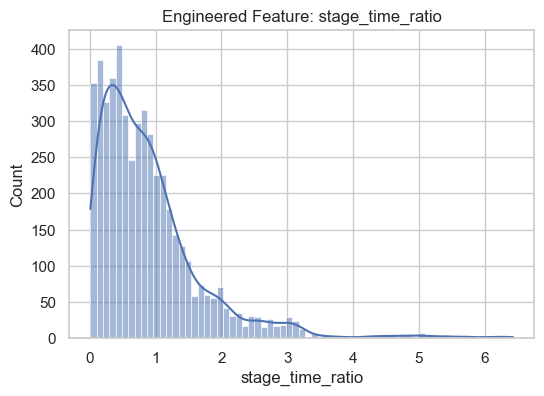

In [10]:
# 6️⃣ Quick feature sanity checks

# Check for missing values after feature engineering
missing_after = df_early_encoded.isnull().sum().sort_values(ascending=False)
missing_after = missing_after[missing_after > 0]
print("Missing values after encoding:", len(missing_after))
display(missing_after.head(20))

# Optional: fill remaining NaNs from ratio divisions
df_early_encoded = df_early_encoded.fillna(0)

# Confirm target distribution still looks good
print("Target distribution (encoded):")
display(df_early_encoded[TARGET_COL].value_counts(normalize=True).round(3))

# Correlation check (numeric only)
numeric_only = df_early_encoded.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number])
plt.figure(figsize=(6,4))
sns.histplot(df_early_encoded["stage_time_ratio"], kde=True)
plt.title("Engineered Feature: stage_time_ratio")
plt.show()


In [14]:
# 7️⃣ Save processed features for training scripts

# Save early-warning dataset
save_processed_data(df_early_encoded, PROCESSED_PATH)

print("✅ Saved early-warning feature dataset to:", PROCESSED_PATH)


✅ Processed dataset saved to: /Users/loictiemani/Documents/sla-risk-prediction/data/processed/sla_cases_clean.csv
✅ Saved early-warning feature dataset to: /Users/loictiemani/Documents/sla-risk-prediction/data/processed/sla_cases_clean.csv


In [15]:
# 8️⃣ (Optional) Create a retrospective dataset (includes total_processing_days)
# Use ONLY if you want to show a post-hoc model explanation, not an early-warning system.

RETRO_PATH = PROCESSED_PATH.replace(".csv", "_retrospective.csv")

df_retro = df_fe.drop(columns=ID_COLS).copy()
df_retro[TARGET_COL] = df_retro[TARGET_COL].astype(int)

cat_cols_retro = df_retro.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if TARGET_COL in cat_cols_retro:
    cat_cols_retro.remove(TARGET_COL)

df_retro_encoded = pd.get_dummies(df_retro, columns=cat_cols_retro, drop_first=True).fillna(0)
df_retro_encoded.to_csv(RETRO_PATH, index=False)

##print("✅ Saved retrospective dataset to:", RETRO_PATH)
##print("Note: retrospective dataset may include leakage features and should not be used for early-warning claims.")
